# Read me

Project where I investigate the idea of using neural networks to classify DNA sequences:

- Generate pseudorandom nucleotide sequences
- Generate point mutations/indels into those sequences based on probabilities for given mutations
- Build a CNN to distinguish sequences with certain of those mutation from other sequences that don't have those mutations

I will represent the sequences using a one-hot encoding matrix (One row for each base) and possibly take a look at Google's Nucleus Package in Tensorflow that's purposed for genomic data handling. Maybe https://github.com/nh13/DWGSIM can also be used to generate sequences?..


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
#import logomaker as lm
from Bio.Seq import Seq
from Bio import motifs
from Bio.Alphabet import generic_dna

## Part 1: Create sequences

In [2]:
bases = ['A', 'T', 'C', 'G'] #Could use codons
seq_length = 100
number_of_seq = 1000
start_sequence = random.choices(bases, k=seq_length)
''.join(start_sequence)

variation_rate = .1
n_variantions = int(round(variation_rate * seq_length))
var_places = np.random.randint(0, seq_length, size=n_variantions)
mutation_pos = np.random.choice(np.setdiff1d(np.arange(seq_length),var_places, assume_unique=True))
print("Is the position for the mutation in the varablie positions? (Should be False):", mutation_pos in var_places)
print(f'Mutation will occur at position {mutation_pos} in the starting sequence')

fixed_base = 'G'
check = fixed_base != start_sequence[mutation_pos]
print('Are original base and new mutated base different?:', check)

print(f'Position {mutation_pos} in the starting sequence will be changed to {fixed_base} from {start_sequence[mutation_pos]}')

print("Starting with sequence:",''.join(start_sequence))

#Each point mutation has preditermined probabilities for a given base occuring at that position.
probs = [np.random.dirichlet(np.ones(4),size=1).flatten() for point in range(n_variantions)]

#For every sequence we have to pick a base for every point mutation given those probabilities

#Healthy sequence: fixed point mutations with probability of occurence represent a "varying healthy gene"

def healthy_gen(seq):
    for i,p in enumerate(var_places):
        base = random.choices(bases, weights=probs[i])[0]
        seq[p] = base
    return seq

#Mutated sequence: Similarly varying as the healthy sequence on certain point mutations, 
#but also contain (a) different mutation(s).
def mutated_gen(seq):
    for i, p in enumerate(var_places):
        base = random.choices(bases, weights=probs[i])[0]
        seq[p] = base
    #Fixed position for "malignant" mutation
    #malignant_base = random.choices(['B', 'B'], weights=[0.3,0.7])[0]
    if check == True:
        seq[mutation_pos] = fixed_base
    return seq

Is the position for the mutation in the varablie positions? (Should be False): False
Mutation will occur at position 74 in the starting sequence
Are original base and new mutated base different?: True
Position 74 in the starting sequence will be changed to G from C
Starting with sequence: TTAATGACATCTAGTATTATACACCGAAAGCCGCGTTAAACCGATCGTCTACGATTAGTCAGCTTTCGCTCGGTCGTTAGTTACGGGCAGGGTTGAGCCT


In [3]:
''.join(start_sequence)

'TTAATGACATCTAGTATTATACACCGAAAGCCGCGTTAAACCGATCGTCTACGATTAGTCAGCTTTCGCTCGGTCGTTAGTTACGGGCAGGGTTGAGCCT'

In [4]:
#The represent the sequences as we would get them from a fasta file
negatives = [''.join(healthy_gen(seq=start_sequence[:])) for i in range(number_of_seq)]
positives = [''.join(mutated_gen(seq=start_sequence[:])) for i in range(number_of_seq)]

print(negatives[0])
print(positives[0])

TTAATGACATCTAGTATTATACACCGAAAGCCTCGCTAAACCGATCGTATACGATAAGTCAGCCTTCGCTCGAGCGTTAGTTACGGCCAGCGTTGAGCCT
TTAATGACATCTAGTATTATACACCGAAAGCTGCGGTAAACCGATCGTCTACGATTAGTCAGCATTCGCTCGGGGGTTAGTTACGGTCAGAGTTGAGCCT


In [5]:
#Data augmentation using the reverse complement
rc_negatives = [str(Seq(x, alphabet=generic_dna).reverse_complement()) for x in negatives]
rc_positives = [str(Seq(x, alphabet=generic_dna).reverse_complement()) for x in positives]
negatives_augmented = negatives+rc_negatives
positives_augmented = positives+rc_positives
print(len(negatives_augmented), len(positives_augmented))

sequences = negatives_augmented + positives_augmented
labels = list(np.zeros(len(negatives_augmented))) + list(np.ones(len(positives_augmented)))

2000 2000


In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#Create data input for CNN
#From https://github.com/NikolayOskolkov/DeepLearningAncientDNA/blob/master/DeepLearningAncientDNA.ipynb

integer_encoder = LabelEncoder() 
one_hot_encoder = OneHotEncoder()  
input_features = []

for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)



#Same for labels

one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Example sequence
-----------------------
DNA Sequence #1:
 TTAATGACAT ... CGTTGAGCCT
One hot encoding of Sequence #1:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]]
Labels:
 [[0. 0. 0. ... 1. 1. 1.]]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [20]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

print(np.sum(train_labels, axis = 0), 
      np.sum(test_labels, axis = 0))

[1476. 1524.] [524. 476.]


In [21]:
train_labels.shape

(3000, 2)

In [22]:
test_features.shape

(1000, 100, 4)

In [23]:
test_labels.shape

(1000, 2)

# CNN 

In [24]:
input_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Working with L1 = 0.1
Param: 0.100000, Train: 0.508, Test: 0.476
Working with L1 = 0.01
Param: 0.010000, Train: 1.000, Test: 1.000
Working with L1 = 0.001
Param: 0.001000, Train: 1.000, Test: 1.000
Working with L1 = 0.0001
Param: 0.000100, Train: 1.000, Test: 1.000
Working with L1 = 1e-05
Param: 0.000010, Train: 1.000, Test: 1.000
Working with L1 = 1e-06
Param: 0.000001, Train: 1.000, Test: 1.000


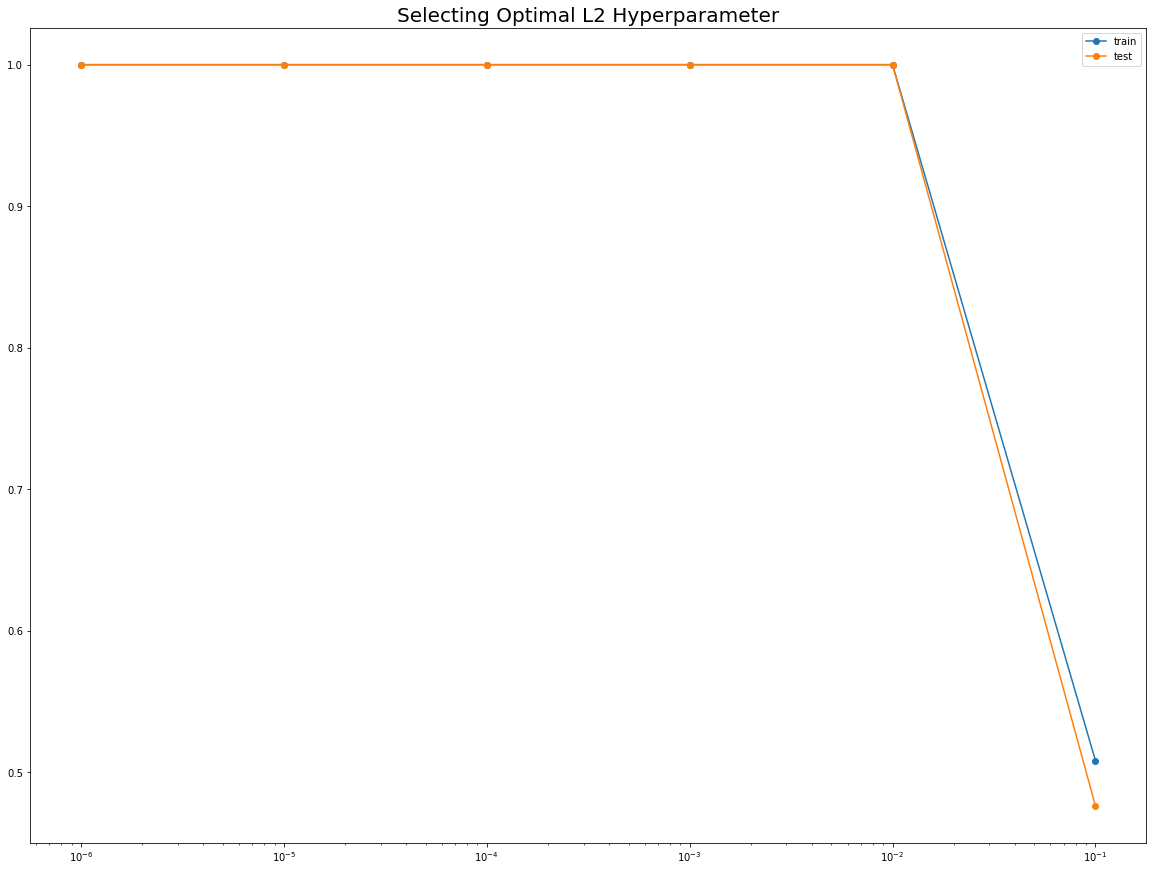

In [22]:
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1

values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()
for param in values:
    
    print('Working with L1 = {}'.format(param))
    
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     input_shape=(train_features.shape[1], 4), activation = 'relu',
                     kernel_regularizer=l1(param)))
    model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                     activation = 'relu', kernel_regularizer=l1(param)))
    model.add(MaxPooling1D(pool_size = 2))
    
    model.add(Flatten())
    model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu', 
                    kernel_regularizer=l1(param)))
    model.add(Dense(2, activation='softmax'))
    
    epochs = 20
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    model.fit(train_features, train_labels, epochs = epochs, verbose = 0, validation_split = 0.25,
              batch_size = 32, shuffle = True)
    
    _, train_acc = model.evaluate(train_features, train_labels, verbose=0)
    _, test_acc = model.evaluate(test_features, test_labels, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f'% (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    
# plot train and test means
plt.figure(figsize=(20,15))
plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.title('Selecting Optimal L2 Hyperparameter', fontsize = 20)
plt.show()

In [ ]:
#Create a Position Weight Matrix with Biopython TODO
#neg_bioseq = [Seq(x) for x in negatives]
#pos_bioseq = [Seq(x) for x in negatives]
#mneg = motifs.create(neg_bioseq)